In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing

In [2]:
file_path = "energydata_complete.csv"
df = pd.read_csv(file_path)

In [3]:
# Convert date column to datetime format (instead of object)
df['date'] = pd.to_datetime(df['date'])

# set date as index because we have 10min intervals i.e uniqueness 
df.set_index('date', inplace=True) 

# To analyse temporal tendencies and have meaningful features, we create the hour, day of the week, month and year features from the date index
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [4]:
X = df.drop(columns=['Appliances', 'rv1', 'rv2'])  
y = df['Appliances']

X.shape, y.shape

((19735, 28), (19735,))

In [5]:
X = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour'], drop_first=True)
X.shape

(19735, 58)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# Check the shape of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((15788, 58), (3947, 58), (15788, 1), (3947, 1))

# Data set and data loader

In [30]:
class EnergyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [31]:
batch_size = 128
train_dataset = EnergyDataset(X_train, y_train)
test_dataset = EnergyDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# MLP

In [42]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        layers.append(nn.Linear(hidden_size, output_size))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [74]:
# Train loop 
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_lossi = []
    test_lossi = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_lossi.append(loss.item())
        
        test_loss = test_model(model, test_loader, criterion)
        test_lossi.append(test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss:.4f}")
    return train_lossi, test_lossi
    
# Test loop
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch, (X, y) in enumerate(train_loader):
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item()
    return total_loss/len(test_loader)

In [101]:
# Let's define the model parameters 
input_size = X_train.shape[1]
hidden_size = 512
output_size = 1
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 100
model = MLP(input_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [105]:
# Training and testing the model
train_lossi, test_lossi = train_model(model, train_loader, criterion, optimizer, num_epochs)
test_model(model, test_loader, criterion)

Epoch [1/100], Loss: 0.3099, Test Loss: 0.8163
Epoch [2/100], Loss: 0.1982, Test Loss: 0.6239
Epoch [3/100], Loss: 0.1777, Test Loss: 0.6128
Epoch [4/100], Loss: 0.1731, Test Loss: 0.5883
Epoch [5/100], Loss: 0.1701, Test Loss: 0.5660
Epoch [6/100], Loss: 0.1655, Test Loss: 0.5927
Epoch [7/100], Loss: 0.1657, Test Loss: 0.5667
Epoch [8/100], Loss: 0.1664, Test Loss: 0.5597
Epoch [9/100], Loss: 0.1644, Test Loss: 0.5713
Epoch [10/100], Loss: 0.1691, Test Loss: 0.5614
Epoch [11/100], Loss: 0.1733, Test Loss: 0.5429
Epoch [12/100], Loss: 0.1631, Test Loss: 0.5574
Epoch [13/100], Loss: 0.1653, Test Loss: 0.5542
Epoch [14/100], Loss: 0.1684, Test Loss: 0.5517
Epoch [15/100], Loss: 0.1614, Test Loss: 0.5474
Epoch [16/100], Loss: 0.1621, Test Loss: 0.5317
Epoch [17/100], Loss: 0.1608, Test Loss: 0.5381
Epoch [18/100], Loss: 0.1622, Test Loss: 0.5225
Epoch [19/100], Loss: 0.1579, Test Loss: 0.5434
Epoch [20/100], Loss: 0.1560, Test Loss: 0.5169
Epoch [21/100], Loss: 0.1534, Test Loss: 0.5399
E

0.4099998147857766

In [97]:
# Display the training and test loss
def plot_losses(train_loss, test_loss, smooth_window=1):
    if smooth_window > 1:
        smoothed_train_loss = np.convolve(train_loss, np.ones(smooth_window)/smooth_window, mode='valid')
        x_train = np.arange(len(smoothed_train_loss)) + (smooth_window - 1) / 2
    else:
        smoothed_train_loss = train_loss
        x_train = np.arange(len(train_loss))
    
    batches_per_epoch = len(train_loss) / len(test_loss)
    x_test = np.array([(i+1)*batches_per_epoch - 1 for i in range(len(test_loss))])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_train, smoothed_train_loss, label='Training Loss (lissé)' if smooth_window > 1 else 'Training Loss')
    plt.plot(x_test, test_loss, marker='o', linestyle='--', label='Test Loss')
    plt.xlabel('Itérations (batches)')
    plt.ylabel('Loss')
    plt.title('Training et Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

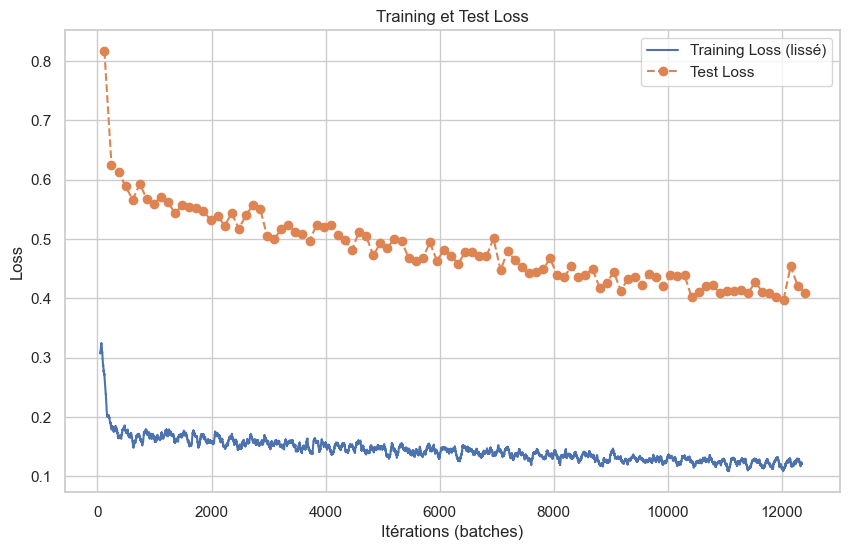

In [106]:
plot_losses(train_lossi, test_lossi, 100)

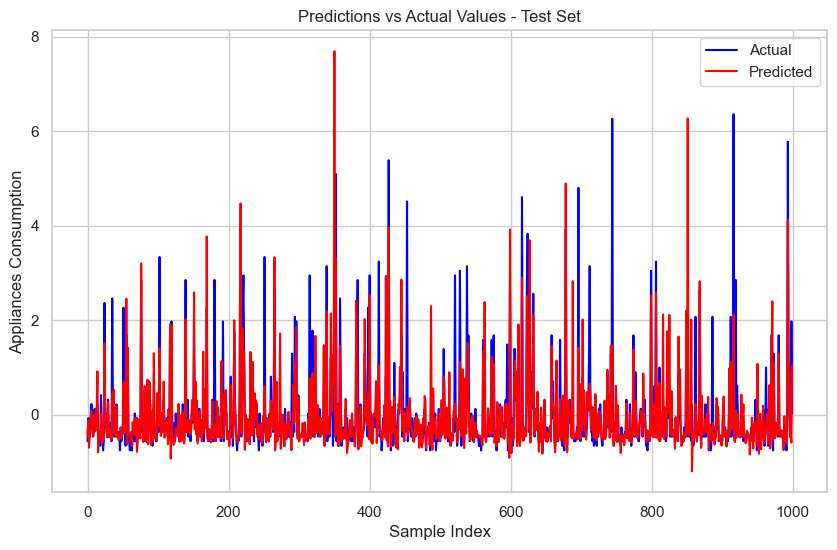

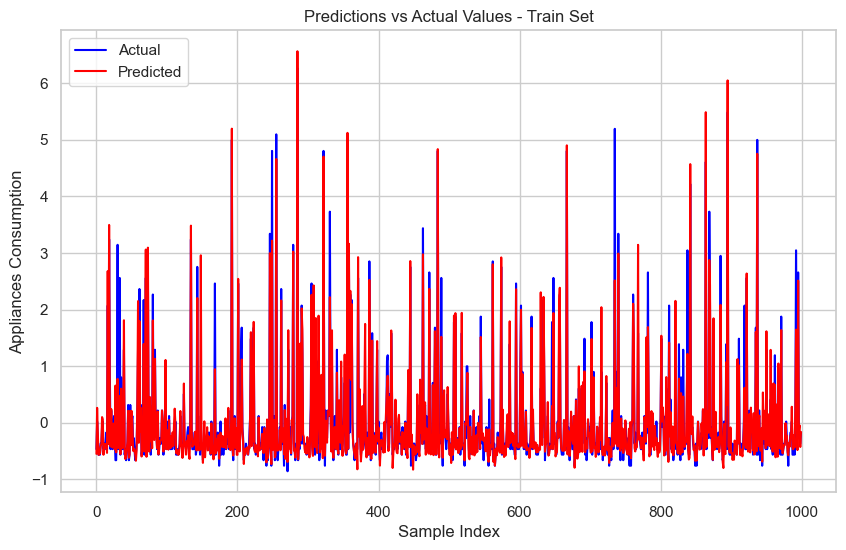

In [107]:
# display the predictions 

span = 1000

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title("Predictions vs Actual Values - Test Set")
plt.xlabel("Sample Index")
plt.ylabel("Appliances Consumption")
plt.plot(y_test[:span], label="Actual", color='blue')
plt.plot(model(torch.tensor(X_test[:span], dtype=torch.float32)).detach().numpy(), label="Predicted", color='red')
plt.legend()
plt.show()

# Same on the training set
plt.figure(figsize=(10, 6))
plt.title("Predictions vs Actual Values - Train Set")
plt.xlabel("Sample Index")
plt.ylabel("Appliances Consumption")
plt.plot(y_train[:span], label="Actual", color='blue')
plt.plot(model(torch.tensor(X_train[:span], dtype=torch.float32)).detach().numpy(), label="Predicted", color='red')
plt.legend()
plt.show()

